In [245]:
import numpy as np
import matplotlib.pyplot as plt

from evoscape.module_helper_functions import modules_from_txt
from evoscape.landscapes import CellDiff_Dataset_Landscape
import evoscape.landscape_visuals as vis
from evoscape.morphogen_regimes import mr_piecewise
from matplotlib.colors import ListedColormap, BoundaryNorm, CenteredNorm, Normalize

import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from matplotlib import colormaps
from matplotlib import style
style.use('default')

In [246]:

plt.rcParams.update({'figure.dpi': 200})  # Change to 200 for high res figures
plt.rcParams.update({'font.size': 15})  
plt.rcParams['axes.grid'] = False

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
data_dir = '../alfyn_results_stage2/saved_files_8/CellDiff_Dataset_Landscape/'
file_name = data_dir + 'optimization_log.csv'

log = pd.read_csv(file_name, sep='\t', names=['Timecode', 'Init timecode', 'Fitness'], skiprows=1)
print(log.shape)

fitness_threshold = -0.55
print(np.sum(log['Fitness'] > fitness_threshold))
timecodes = log['Timecode'][log['Fitness'] > fitness_threshold]


def landscape_from_timecode(timecode, data_dir, gen, landscape_pars):
    filename = data_dir + timecode + '/' + timecode + '_module_list_' + str(gen) + '.txt'
    with open(filename, 'r') as f:
        module_list = modules_from_txt(filename)
    landscape = CellDiff_Dataset_Landscape(module_list, A0=landscape_pars['A0'], regime=mr_piecewise, n_regimes=5)
    return landscape

landscape_pars = {
    'A0': 0.005,
}
gen = 300

(241, 3)
59


In [239]:
def transform_coords(landscape, old_coords, origin=0, direction=2, left=None, right=None, bottom=None, scale=False):
    module_coords = np.zeros((len(landscape.module_list), 2))
    for i, module in enumerate(landscape.module_list):
        module_coords[i, :] = module.x, module.y
    coords = old_coords - module_coords[origin]   # move origin 
    module_coords = module_coords - module_coords[origin]
    
    x, y = np.mean(module_coords[direction, 0]), np.mean(module_coords[direction, 1])

    d = np.linalg.norm((x, y))  
    R = np.array([[x, y], [-y, x]])/d
    coords = (R @ coords.T).T  # rotate to align with direction module
    module_coords = (R @ module_coords.T).T
    
    if bottom is not None:
        if module_coords[bottom, 1] > 0:    # flip the y-axis if needed
            coords[:, 1] *= -1.
    if left is not None:
        if module_coords[left, 0] > 0:     # flip the x-axis if needed
            coords[:, 0] *= -1.
    if right is not None:
        if module_coords[right, 0] < 0:     # flip the x-axis if needed
            coords[:, 0] *= -1.
            
    if scale:
        coords /= np.max(np.abs(coords))
        
    return coords

In [257]:
def rotate_landscape(landscape, origin=0, direction=2, left=None, right=None, bottom=None):
    module_coords = np.zeros((len(landscape.module_list), 2))
    for i, module in enumerate(landscape.module_list):
        module_coords[i, :] = module.x, module.y
    x0 = np.zeros((1, 2))
    x0 -= module_coords[origin]
    module_coords = module_coords - module_coords[origin]
    
    x, y = np.mean(module_coords[direction, 0]), np.mean(module_coords[direction, 1])
    d = np.linalg.norm((x, y))  
    R = np.array([[x, y], [-y, x]])/d
    x0 = (R @ x0.T).T
    module_coords = (R @ module_coords.T).T
    
    if bottom is not None:
        if module_coords[bottom, 1] > 0:    # flip the y-axis if needed
            module_coords[:, 1] *= -1.
            x0[0, 1] *= -1.
    if left is not None:
        if module_coords[left, 0] > 0:     # flip the x-axis if needed
            module_coords[:, 0] *= -1.
            x0[0, 0] *= -1.
    if right is not None:
        if module_coords[right, 0] < 0:     # flip the x-axis if needed
            module_coords[:, 0] *= -1.
            x0[0, 0] *= -1.
    for i, module in enumerate(landscape.module_list):
        module.x, module.y = module_coords[i, :]
    landscape.x0 = x0[0]
    
    return landscape
        
            

In [113]:
%autoreload

L = 4.
npoints = 201
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')

noise = 0.2
ndt = 50
nt = 61
ncells = 300


init_state = 2

delta=2.
morphogen_times = (delta*1, delta*3, delta*7, delta*7)
time_pars = (0, delta*7, nt)


morphogen_times = (delta*0, delta*1.5, delta*7, delta*7)
time_pars = (0, delta*3, nt)

n_landscapes = len(timecodes)
# n_landscapes = 5
Q = np.zeros((n_landscapes, nt*ncells*2))


for i in range(n_landscapes):
    # print(i)
    timecode = timecodes.iloc[i]
    landscape = landscape_from_timecode(timecode, data_dir, gen, landscape_pars)
    landscape.morphogen_times = morphogen_times

    landscape.init_cells(ncells, init_state, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise, ndt=ndt, frozen=False)
    
    data = traj.transpose(1,2,0).reshape(-1, 2)
    # fig, ax = vis.visualize_cell_states(landscape, xx, yy, t, 0)
    # ax.scatter(data[:,0], data[:, 1], color='k', alpha=0.3, marker='.', s=5)
    # plt.show()
        
    st_data = transform_coords(landscape, data, origin=2, direction=(3, 4), left=None, right=4, bottom=4, scale=True)
    # scaler = StandardScaler()
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # st_data = scaler.fit_transform(data)
    
    # fig, ax = plt.subplots(1,1, figsize=(4,4))
    # ax.scatter(st_data[:,0], st_data[:, 1], cmap='viridis', c=range(data.shape[0]), alpha=0.3, marker='.', s=5)
    # plt.show()

    
    flat_data = st_data.flatten()
    Q[i] = flat_data
        


/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:271: RuntimeWarning: divide by zero encountered in divide
  -np.sum((coordinate.T - np.array((module.x, module.y))) ** 2, axis=1) / 2. / st ** 2) / st ** 2
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:270: RuntimeWarning: invalid value encountered in divide
  prob[:, i] = np.exp(
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:60: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)


In [153]:
n_components = 15  # Number of principal components to retain
pca = PCA(n_components=n_components)
pca_transformed = pca.fit_transform(Q)

# Reconstruct data from PCA components
Q_reconstructed = pca.inverse_transform(pca_transformed)

# Reshape back to original trajectory shape (n_landscapes, nt, ncells, 2)
Q_reconstructed = Q_reconstructed.reshape(n_landscapes, -1, 2)
Q_original = Q.reshape(n_landscapes, -1, 2)


# Print explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)




Explained variance ratio: [0.22017187 0.13709592 0.06051767 0.03030336 0.02765972 0.0253069
 0.02462604 0.02238169 0.02050928 0.01971873 0.01888352 0.01830484
 0.01722387 0.01644136 0.01576273]


0.5016820777287839


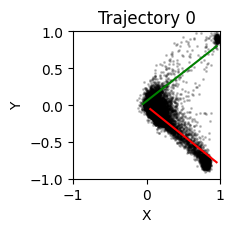

1.279200060330867


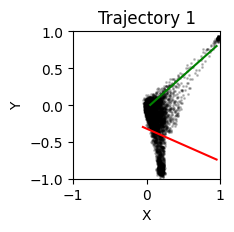

0.9245171949432549


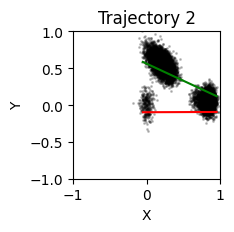

1.2826170100075267


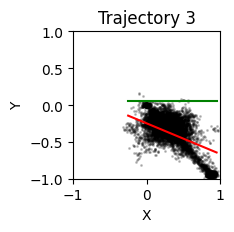

0.7313550187211402


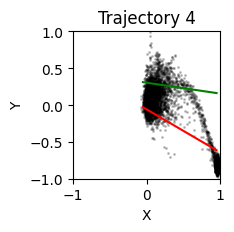

1.1770204969968754


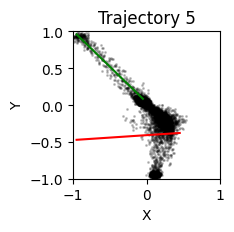

1.267325640896922


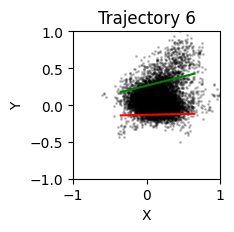

0.5554571485554733


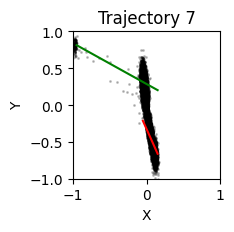

0.8695766968880179


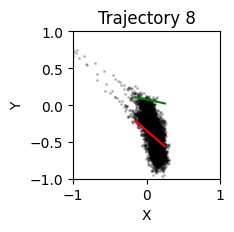

1.1141242079527078


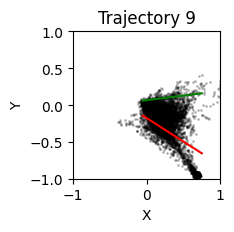

0.6374290316594394


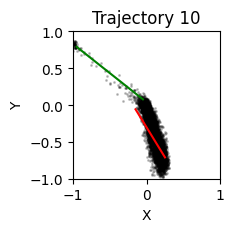

0.31332142857142853


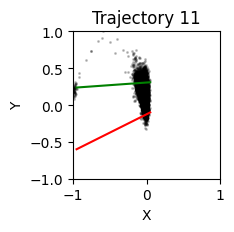

0.5304481143694189


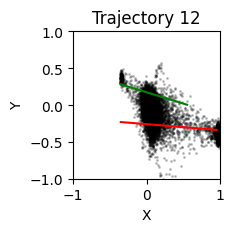

1.2630352738549258


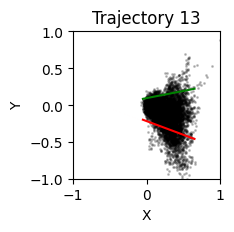

1.3538278469299736


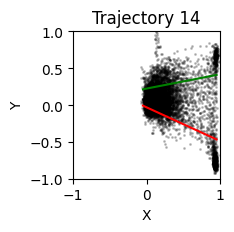

0.12914187287547066


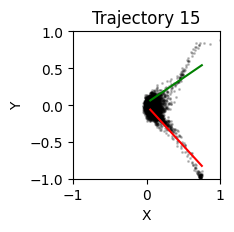

0.2532427337550668


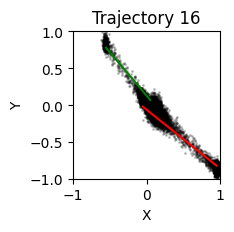

0.49954828049013955


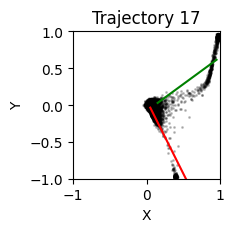

0.44894287817764494


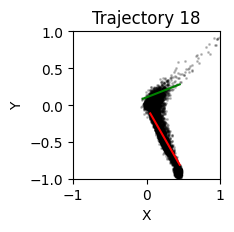

2.257055322128852


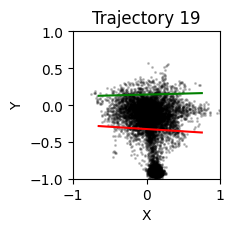

0.39057678311499283


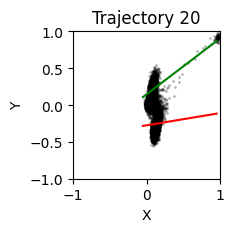

3.9990159911336294


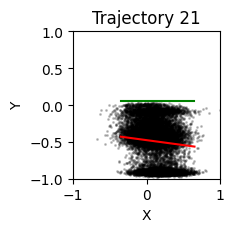

0.5163401753686728


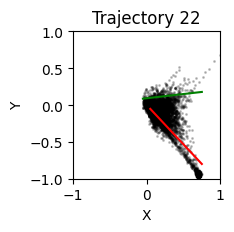

0.7341997399164972


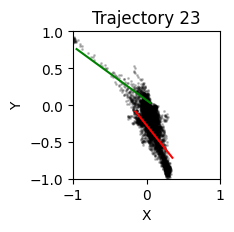

1.0973367035873904


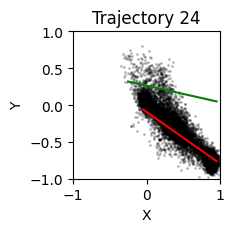

0.9287767857142858


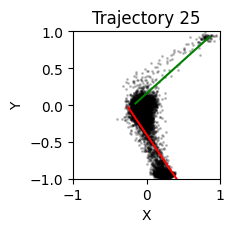

1.572789089369713


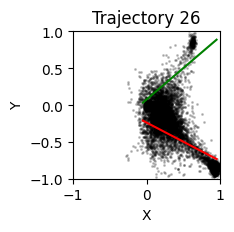

0.5569780750137895


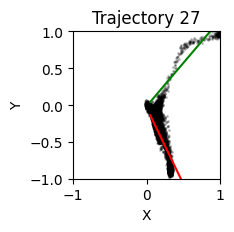

1.3014591027079259


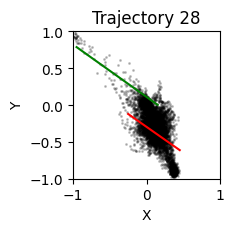

0.8175990155677657


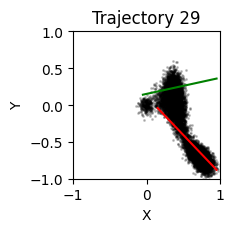

0.8274094343804361


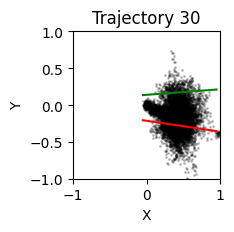

0.7517199615556512


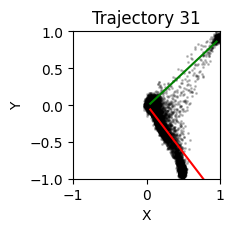

1.625144303431533


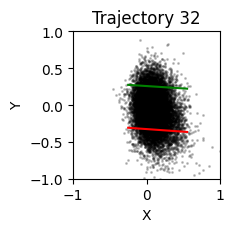

0.9009757604803275


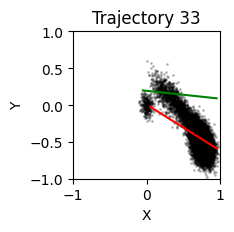

0.9007523971101243


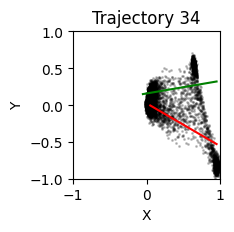

0.6066597267562566


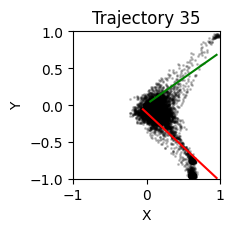

1.3178958108392653


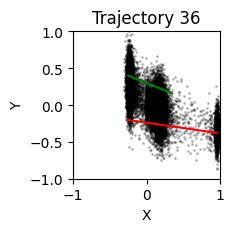

0.14384655224919035


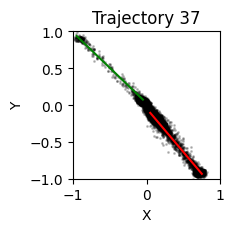

1.0754716390849037


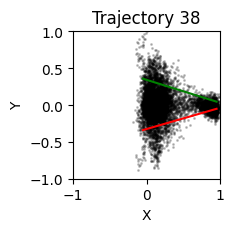

0.9777176708146589


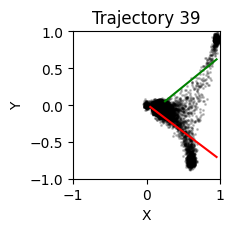

1.5582662359178265


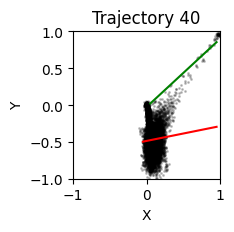

0.3115179498318864


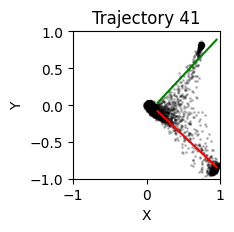

0.970687740322302


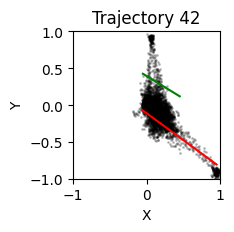

0.17207355125002188


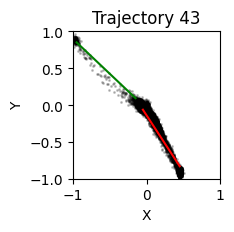

1.421576164992207


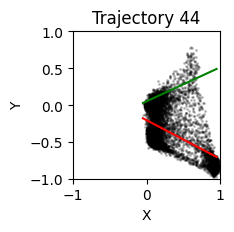

0.8643374082519916


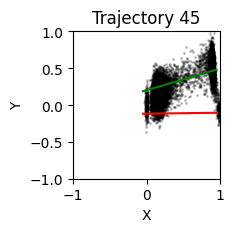

1.3372842544518846


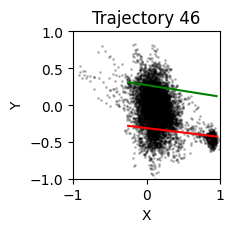

1.5443311784756064


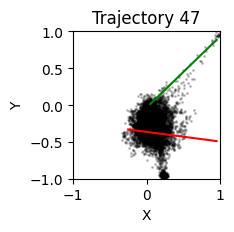

0.690423735936067


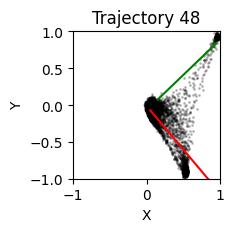

0.33712622036262213


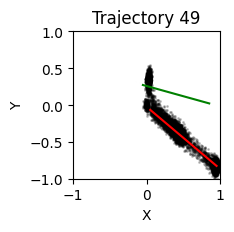

In [193]:

num_samples = 50
sample_indices = np.random.choice(n_landscapes, num_samples, replace=False)
sample_indices = np.arange(num_samples)

# for idx, i in enumerate(sample_indices):
#     plt.figure(figsize=(2.5, 2.5))
#     plt.scatter(Q_original[i][:, 0], Q_original[i][:, 1], c='b', label="Original", marker='.', s = 5)
#     plt.xlabel("X")
#     plt.ylabel("Y")
#     # plt.legend()
#     plt.title(f"Trajectory {i}")
#     plt.xlim((-1, 1))
#     plt.ylim((-1, 1))
#     ax = plt.gca()
#     ax.set_aspect('equal')
# plt.tight_layout()
# plt.show()

Q_original = Q.reshape(n_landscapes, -1, 2)


# plt.figure(figsize=(6, 6))
for idx, i in enumerate(sample_indices):
    
    data = Q_original[i][:, 0:2]
    
    # eps = 0.1
    # db = DBSCAN(eps=eps, min_samples=15)
    # labels = db.fit_predict(data)
    
    # gmm = GaussianMixture(n_components=3, random_state=42)
    # labels = gmm.fit_predict(data)
    
    
    x_bins = np.linspace(-1, 1, 21)
    density, x_edges, y_edges = np.histogram2d(data[:, 0], data[:, 1], bins=[x_bins, x_bins])
    density_mask = density.T>10
    bin_centers = (x_bins[:-1] + x_bins[1:]) / 2
    X, Y = np.meshgrid(bin_centers, bin_centers)

    
    
    # x, y = data[:, 0], data[:, 1]
    x = X[density_mask]
    y = Y[density_mask]
    r2 = np.sqrt(x**2 + y**2)
    x_sorted = np.sort(x)
    mask1 = (y < 0) * (r2>0.0)
    mask2 = (y >= 0) * (r2>0.0)

    # coeffs1 = np.polyfit(x[mask1], y[mask1], 1, w=r2[mask1])
    coeffs1 = np.polyfit(x[mask1], y[mask1], 1, w=None)
    error1 = np.sum((np.polyval(coeffs1, x[mask1]) - y[mask1])** 2)
    # coeffs2 = np.polyfit(x[mask2], y[mask2], 1, w=r2[mask2])
    coeffs2 = np.polyfit(x[mask2], y[mask2], 1, w=None)
    error2 = np.sum((np.polyval(coeffs2, x[mask2]) - y[mask2]) ** 2, )
    print(np.mean((error1, error2)))
    
    plt.figure(figsize=(2.5, 2.5))
    plt.scatter(Q_original[i][:, 0], Q_original[i][:, 1], label="Original", marker='.', s = 5, alpha=0.2, c='k')    
    # plt.scatter(X[density_mask], Y[density_mask], label="Original", marker='.', s = 5, alpha=1, c='b')    
    
    line1 = np.polyval(coeffs1, x_sorted)
    line2 = np.polyval(coeffs2, x_sorted)
    plt.plot(x_sorted[line1<0], line1[line1<0], 'r-')
    plt.plot(x_sorted[line2>0], line2[line2>0], 'g-')
    
    
    
    
    # plt.scatter(Q_original[i][:, 0], Q_original[i][:, 1], label="Original", marker='.', s = 5, alpha=0.2, c=labels, cmap='viridis')  
    # plt.scatter(Q_reconstructed[i][:, 0], Q_reconstructed[i][:, 1], c='r', label="Reconstructed", marker='.', s = 5)

    # hull = ConvexHull(data)
    # for simplex in hull.simplices:
    #     plt.plot(data[simplex, 0], data[simplex, 1], 'r-', lw=1)

    # plt.scatter(Q_reconstructed[i][:, 0], Q_reconstructed[i][:, 1], c='r', label="Reconstructed", marker='.', s = 5)
    plt.xlabel("X")
    plt.ylabel("Y")
    # plt.legend()
    plt.title(f"Trajectory {i}")
    plt.xlim((-1, 1))
    plt.ylim((-1, 1))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.show()





16


/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:272: RuntimeWarning: divide by zero encountered in divide
  -np.sum((coordinate.T - np.array((module.x, module.y))) ** 2, axis=1) / 2. / st ** 2) / st ** 2
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:271: RuntimeWarning: invalid value encountered in divide
  prob[:, i] = np.exp(
/Users/victoria/Code/landscapes/src/evoscape/landscapes/landscape_class.py:61: RuntimeWarning: divide by zero encountered in divide
  weight = np.exp(-0.5 * (r / sig) ** 2)


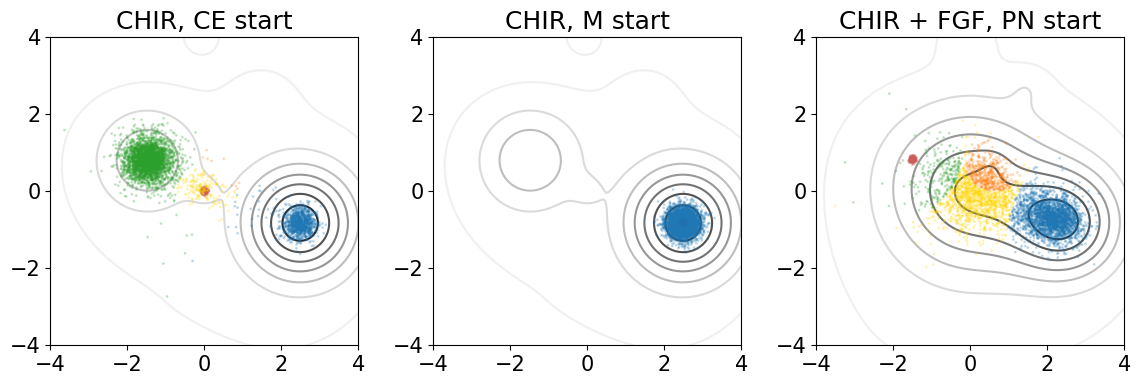

18


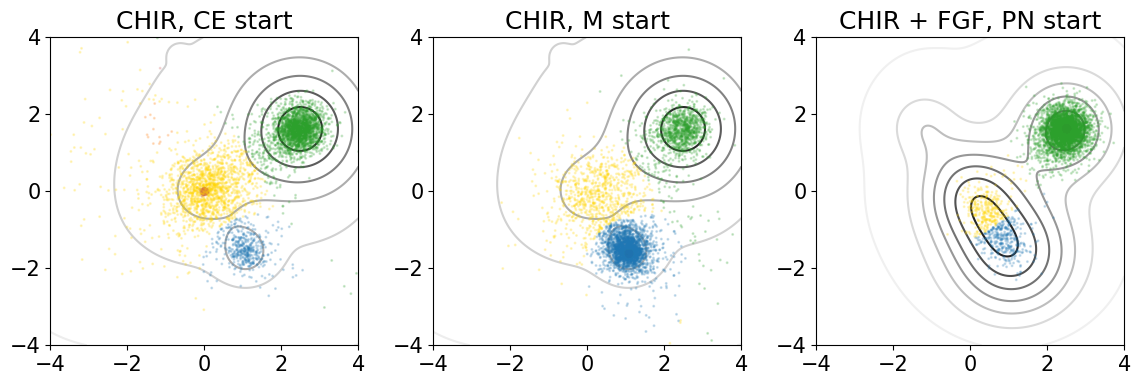

21


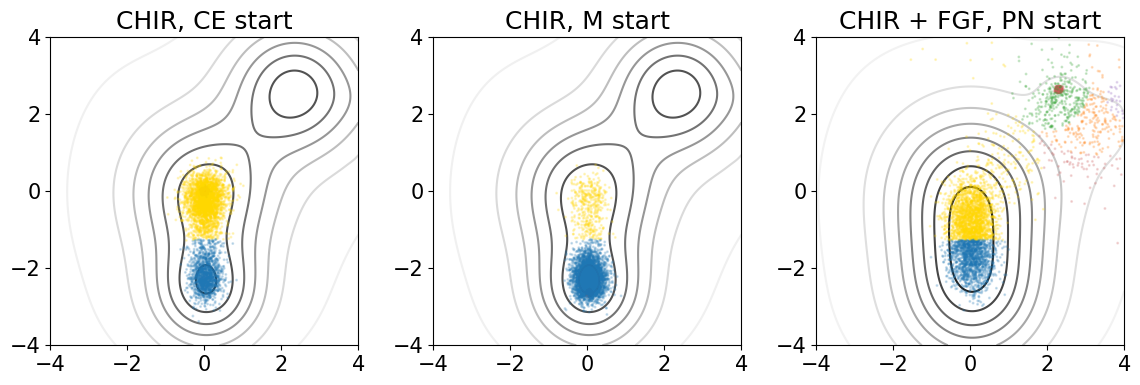

22


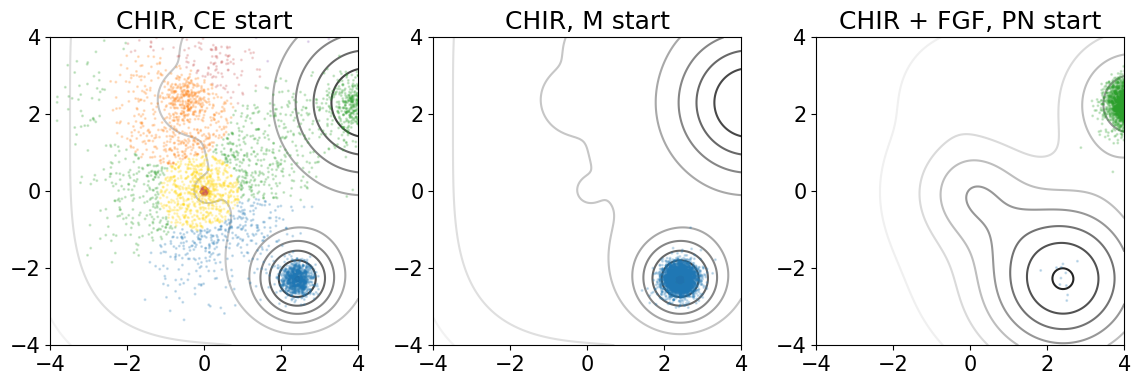

41


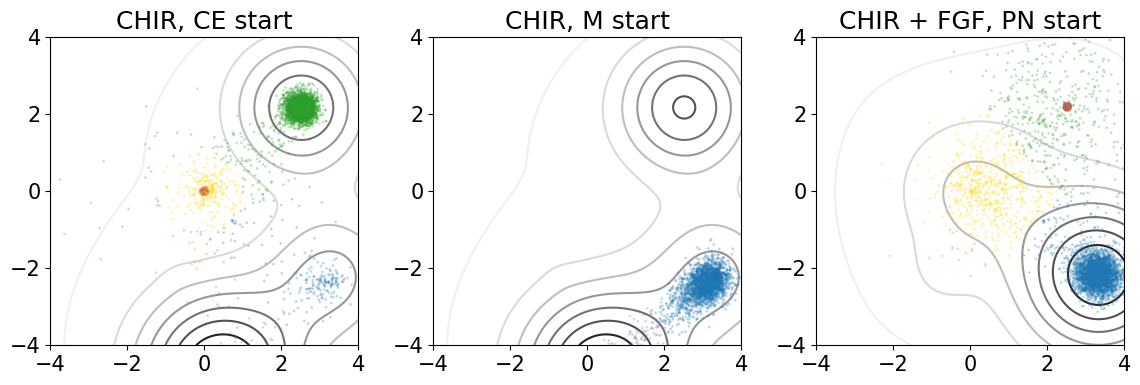

57


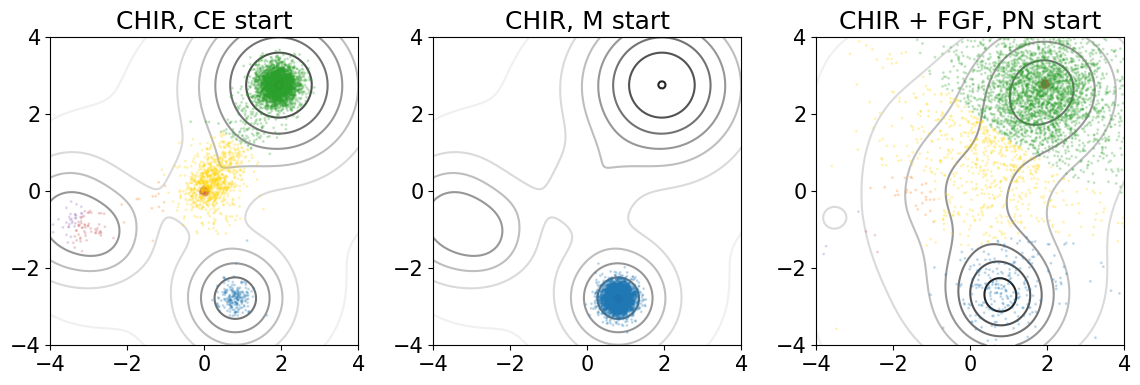

In [294]:
%autoreload

L = 4.
npoints = 201
q = np.linspace(-L, L, npoints)
xx, yy = np.meshgrid(q,q, indexing = 'xy')

colors = ('indianred', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple')
cmap_state = ListedColormap(colors)
norm_state = BoundaryNorm(np.arange(len(colors)+1) - 0.5, cmap_state.N)

noise = 0.2
ndt = 50
nt = 12
ncells = 400


init_state = 2

delta=2.
# morphogen_times = (delta*1, delta*3, delta*7, delta*7)
# time_pars = (0, delta*7, nt)


morphogen_times = (-delta*1, delta*1.5, delta*7, delta*7)
morphogen_times_2 = (-delta*1, -delta*1., delta*7, delta*7)  # Chir
morphogen_times_3 = (-delta*1, delta*5., delta*7, delta*7)   # Chir + FGF




time_pars = (0, delta*3, nt)

n_landscapes = len(timecodes)
n_landscapes = 58

# for i in (14, 34, 44, 48):   # flips 
for i in (16, 18, 21, 22, 41, 57):   # choices

    print(i)
    timecode = timecodes.iloc[i]
    landscape = landscape_from_timecode(timecode, data_dir, gen, landscape_pars)
    landscape.morphogen_times = morphogen_times

    # landscape.init_cells(ncells, init_state, noise/5)
    # traj, states = landscape.run_cells(*time_pars, noise, ndt=ndt, frozen=False)
    # data = traj.transpose().reshape(-1, 2)
    # states = states.transpose().reshape(-1, 1)
    # st_data = transform_coords(landscape, data, origin=2, direction=(3, 4), left=None, right=4, bottom=4, scale=False)
    # 
    fig, ax = plt.subplots(1,3, figsize=(14,4))
    # ax[0].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=5, marker='.',  alpha=0.2)
    # ax[0].set_title('CE start')

    
    landscape.morphogen_times = morphogen_times_2
    
    landscape.init_cells(ncells, 2, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise*5, ndt=ndt, frozen=False)
    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape, data, origin=2, direction=(3, 4), left=None, right=4, bottom=4, scale=False)
    ax[0].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=5, marker='.',  alpha=0.2)
    ax[0].set_title('CHIR, CE start')
    
    landscape.init_cells(ncells, 4, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise*5, ndt=ndt, frozen=False)

    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape, data, origin=2, direction=(3, 4), left=None, right=4, bottom=4, scale=False)
    ax[1].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=5, marker='.',  alpha=0.2)
    ax[1].set_title('CHIR, M start')

 # _______________________________________________   
    
    landscape.morphogen_times = morphogen_times_3
    landscape.init_cells(ncells, 3, noise/5)
    traj, states = landscape.run_cells(*time_pars, noise*7, ndt=ndt, frozen=False)

    data = traj.transpose().reshape(-1, 2)
    states = states.transpose().reshape(-1, 1)
    st_data = transform_coords(landscape, data, origin=2, direction=(3, 4), left=None, right=4, bottom=4, scale=False)
    ax[2].scatter(st_data[:, 0], st_data[:, 1], c=states, cmap=cmap_state, norm=norm_state, s=5, marker='.',  alpha=0.2, edgecolor=None)
    ax[2].set_title('CHIR + FGF, PN start')
    
    landscape = rotate_landscape(landscape, origin=2, direction=(3, 4), left=None, right=4, bottom=4)
    derivs, pot, rot = landscape(delta*6., (xx,yy), return_potentials=True)
    ax[0].contour(xx, yy, pot, zorder=0, cmap='Greys_r')
    ax[1].contour(xx, yy, pot, zorder=0, cmap='Greys_r')
    derivs, pot, rot = landscape(0., (xx, yy), return_potentials=True)
    ax[2].contour(xx, yy, pot, zorder=0, cmap='Greys_r')
    
    for axi in ax:
        axi.set_ylim((-L,L))
        axi.set_xlim((-L,L))
        axi.set_yticks((-4, -2, 0, 2, 4))
        axi.set_aspect('equal')
    plt.show()


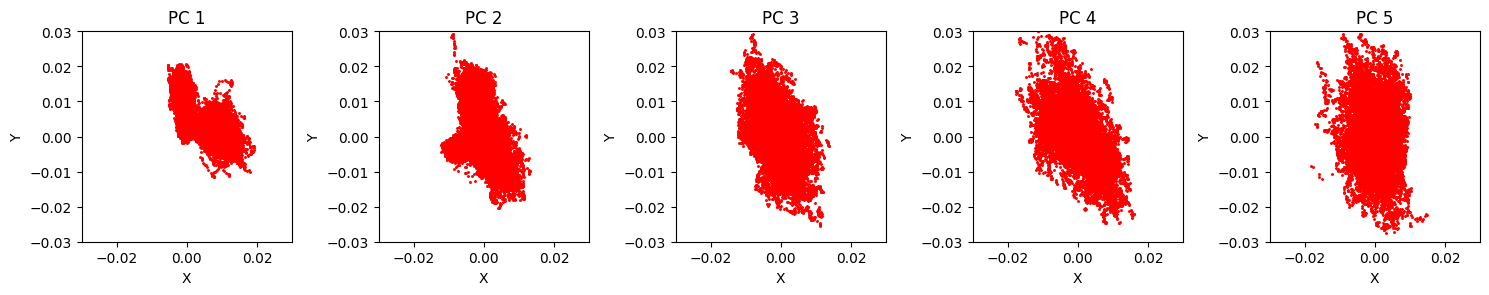

In [59]:
# Number of principal components to visualize
num_components_to_plot = 5

# Reshape PCA components into trajectory format (nt, ncells, 2)
trajectory_shape = (-1, 2)  # Assuming nt * ncells -> trajectory points
pca_components = pca.components_.reshape(num_components_to_plot, *trajectory_shape)

# Plot PCA components as trajectories
plt.figure(figsize=(15, 3))
for i in range(num_components_to_plot):
    plt.subplot(1, num_components_to_plot, i + 1)
    plt.scatter(pca_components[i][:, 0], pca_components[i][:, 1], c='r', marker='.', s = 5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(f"Principal Component {i+1}")
    plt.xlim((-0.03, 0.03))
    plt.ylim((-0.03, 0.03))
    plt.title(f"PC {i+1}")
    ax = plt.gca()
    ax.set_aspect('equal')
    
plt.tight_layout()
plt.show()

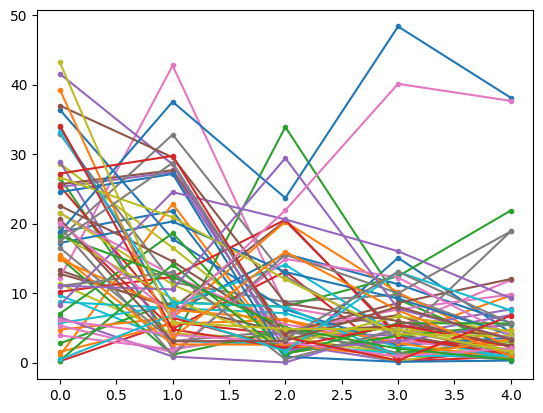

In [65]:
for i in range(n_landscapes):
    plt.plot(np.abs(pca_transformed[i, :5]), '.-')